<a href="https://colab.research.google.com/github/EduardMozharov/ML/blob/main/Project_Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project "Emotion Detection"
Итоговая работа курса SKILLBOX:  
Data Science. ML. Средний уровень (Нейронны сети))

# Задание
**Цель** - реализовать нейронную сеть, распознающую эмоции

**Задачи:**
1. Работа требует реализации алгоритма, с помощью которого будет происходить заданная классификация. Приветствуется использование архитектур свёрточных нейронных сетей, разобранных во время теоретических занятий. Время инференса сети на Google Colab не должно превышать 0,33 секунды (3 кадра в секунду).

2. Создать скрипт, который будет работать с их веб-камерами и выводить на экран текущую эмоцию.


**Дополнительно:**  
1. Используйте подходы по искусственному увеличению датасета для обучения, а именно — аргументации, рассмотренные в курсе.
2. Используйте продвинутые техники обучения, такие как finetuning и другие, рассмотренные в курсе.
3. Пишите структурный код (основная логика кода должна быть вынесена в классы/методы/функции + осмысленный нейминг сущностей и комментарии).
4. Проведите эксперименты с valence-arousal разложением эмоций, когда модель обучается не на самих эмоциях, а на их разложении по этим двум компонентам. Информация о подобном разложении есть в дополнительных материалах.

 
Работающий прототип из пункта «Улучшение и дополнения к заданию» прибавляет один балл к итоговой оценке и добавляет в портфолио ценный ML-проект.




## Отправка результата на проверку
Метрика данного соревнования categorisation accuracy.

Формат решения
Для каждого изображения в тестовом датасете, файл с решением должен содержать две колонки: image_path и emotion. image_path -- название изображение. Имеет формат k.jpg, где k натуральное число от 0 до 4999. emotion -- название предсказанной эмоции для данного изображение. Все представленные в задании эмоции вы можете найти на странице с описанием данных.

Итоговый csv файл должен иметь названия колонок и иметь структуру, как представлено ниже

image_path,emotion  
0.jpg,neutral  
1.jpg,angry  
2.jpg,sad  
3.jpg,contempt  

# 1 Загрузим необходимые библиотеки

In [1]:
DO_IT = False # Выполнять ли особые части кода

In [2]:
!pip install livelossplot

# Для работы оптимизатора TensorRT может потребоваться предыдущая версия tensorflow
#!pip install -U tensorflow==2.7.0
#!pip install keras==2.6.*

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

import tensorflow as tf
print('TensorFlow version:', tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from livelossplot.tf_keras  import PlotLossesCallback

import timeit

TensorFlow version: 2.11.0


#2. Загрузим данные и рассмотрим их

## 2.1 Загрузим рисунки

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
# Один раз загрузим и разархивируем данные на личный диск,
# чтобы каждый раз заново не загружать данные
path = '/content/drive/MyDrive/SKILLBOX/FinalWorks/ML/'
#os.chdir(path)
#!unzip -q train.zip
#!unzip -q test_kaggle.zip

## 2.2. Загрузим табличные данные и рассмотрим их

In [6]:
# Загрузим таблицу с описанием данных train
df = pd.read_csv(path+'train.csv')
n_data = df.shape[0]
print('Количество строк данных', n_data)
df.head()

Количество строк данных 50046


,Unnamed: 0,image_path,emotion
0,0,./train/anger/0.jpg,anger
1,1,./train/anger/1.jpg,anger
2,2,./train/anger/10.jpg,anger
3,3,./train/anger/100.jpg,anger
4,4,./train/anger/1000.jpg,anger


In [7]:
emotions = df.emotion.unique()
n_emotions = emotions.shape[0]

print("Всего эмоций {}: {} ".format(n_emotions, emotions))

Всего эмоций 9: ['anger' 'contempt' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise'
 'uncertain'] 


**image_path** - строка, являющаюся путем до изображения в случае обучения или названием изображения в случае теста  
**emotion** - строка, характеризующая эмоцию  

  
В данном задании требуется предсказать 9 базовых эмоций, таких как:  
* **neutral** - нейтральная эмоция
* **anger**- гнев, злость
* **contempt** - презрение
* **disgust** - отвращение
* **fear** - страх
* **happy** - веселый
* **sad** - грусть
* **surprise** - удивленность
* **uncertain** - неуверенность

In [ ]:
df_count = df.groupby('emotion').count()['image_path']
df_count

emotion
anger        7022
contempt     3085
disgust      3155
fear         5044
happy        5955
neutral      6795
sad          6740
surprise     6323
uncertain    5927
Name: image_path, dtype: int64

## 2.3 Рассмотрим рисунки

In [ ]:
def show_img(img_ind=1):
  img = plt.imread(path+df['image_path'][img_ind][2:])
  plt.imshow(img)
  plt.title(df['emotion'][img_ind])

def show_random_test_img(n_img=10):
    plt.figure(figsize=(20,10))
    for i in range(n_img):
        plt.subplot(4,8, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img_ind = random.randint(0, n_data)
        show_img(img_ind)

In [ ]:
if DO_IT: 
  show_img(1)

In [ ]:
if DO_IT:
  show_random_test_img(n_img=16)

# 3. Рассмотрим тестовые данные

In [ ]:
path_test = path + 'test_kaggle/'    # Путь к тестовым изображениям
path_test_new = path_test + '1/'  # Путь, куда переместим данные
 
'''
get_files = os.listdir(path_test)
for g in get_files:
  if g != '1':
    os.replace(path_test + g, path_test_new + g)
'''

"\nget_files = os.listdir(path_test)\nfor g in get_files:\n  if g != '1':\n    os.replace(path_test + g, path_test_new + g)\n"

In [ ]:
def show_test_img(n_img=0):
  img = plt.imread(path_test_new + str(n_img) + '.jpg')
  plt.imshow(img)

if DO_IT:
  show_test_img(n_img=1)  

# 4. Подготовка данных. Аугментация.


In [ ]:
BATCH_SIZE = 128
IMG_SHAPE  = 64
VAL_PART = 0.2    # Размер валидационной выборки от исходных данных 
RANDOM_STATE = 17

## 4.1 Разобью выборку на обучающую и валидационную

In [ ]:
df['img_path_new'] = df['image_path'].apply(lambda x: x[2:])

In [ ]:
# Перемешаем случайным образом строки и выбирем 
df_train, df_val = np.split(df.sample(frac=1, random_state=RANDOM_STATE), [int((1-VAL_PART)*len(df))])

print('Размер обучающей выборки:', len(df_train))
print('Размер валидационной выборки:', len(df_val))

Размер обучающей выборки: 40036
Размер валидационной выборки: 10010


In [ ]:
# Проверим, что попали разные эмоции в каждую из выборок
print(df_train.groupby('emotion').count()['image_path'])
print('-------------------')
print(df_val.groupby('emotion').count()['image_path'])

emotion
anger        5627
contempt     2468
disgust      2562
fear         3940
happy        4745
neutral      5476
sad          5377
surprise     5064
uncertain    4777
Name: image_path, dtype: int64
-------------------
emotion
anger        1395
contempt      617
disgust       593
fear         1104
happy        1210
neutral      1319
sad          1363
surprise     1259
uncertain    1150
Name: image_path, dtype: int64


## 4.2 Выполним Аугментацию данных и создадим генераторы данных

In [ ]:
# Выполним Аугментацию
train_image_generator = ImageDataGenerator(
      rescale=1./255,
      rotation_range=10,  # максимальный угол поворота
      width_shift_range=0.2, # смещение максимум на 20% ширины по горизонтали
      height_shift_range=0.2, # смещение максимум на 20% высоты по вертикали
      zoom_range=0.2, # картинка будет увеличена или уменьшена не более чем на 20% 
      horizontal_flip=False, # случайное отражение по горизонтали
      vertical_flip=False, # случайное отражение по вертикали
      fill_mode="nearest", # чем заполнять пробелы -- сначала выберем черный цвет, а потом изменим на "nearest"
      #cval=0,
      ) 

val_image_generator = ImageDataGenerator(
      rescale=1./255,
      rotation_range=10,  # максимальный угол поворота
      width_shift_range=0.2, # смещение максимум на 20% ширины по горизонтали
      height_shift_range=0.2, # смещение максимум на 20% высоты по вертикали
      zoom_range=0.2, # картинка будет увеличена или уменьшена не более чем на 20% 
      horizontal_flip=False, # случайное отражение по горизонтали
      vertical_flip=False, # случайное отражение по вертикали
      fill_mode="nearest", # чем заполнять пробелы -- сначала выберем черный цвет, а потом изменим на "nearest"
      #cval=0,
      ) 

In [ ]:
%%time
# Создадим генератор на основе тренировочных данных
train_data_gen = train_image_generator.flow_from_dataframe(df_train, directory=path,
                                                           x_col='img_path_new', y_col='emotion',
                                                           batch_size=BATCH_SIZE,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                           class_mode='categorical')

Found 40036 validated image filenames belonging to 9 classes.
CPU times: user 2.38 s, sys: 2.57 s, total: 4.95 s
Wall time: 4min 16s


In [ ]:
# Создадим генератор на основе валидационных данных
val_data_gen = val_image_generator.flow_from_dataframe(df_val, directory=path,
                                                           x_col='img_path_new', y_col='emotion',
                                                           batch_size=BATCH_SIZE,
                                                           shuffle=False,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                           class_mode='categorical')

Found 10010 validated image filenames belonging to 9 classes.


In [ ]:
def show_faces(images, labels, predicted_labels=None, emotions=emotions):
  # Демонстрирует изображения с подписями, и при наличии - их предсказаниями
    plt.figure(figsize=(20,10))
    for i in range(32):
        plt.subplot(4,8, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {emotions[labels[i]]}. Pred: {emotions[np.argmax(predicted_labels[i])]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {emotions[np.argmax(labels[i])]}")

In [ ]:
#Посмотрим, что выдает генератор тренеровочных данных
if DO_IT:
  example_32_img = train_data_gen.next()[:32]
  show_faces(example_32_img[0], example_32_img[1], predicted_labels=None, emotions=emotions)

#5. Модель #1 - небольшая классическая сверточная нейронная сеть (CNN)

В ходе выполнения работы придерживаемся следующих правил по оптимизации времения выполнения сети:
1) Оптимизация модели при обучении:
   * 1.1)  От простой модели к сложной.
   * 1.2) Не заставлять учить то, что задается явно.
   * 1.3) Понизить ширину сети за счет Conv(1х1).
   * 1.4) Заменить Conv+Pool2D на Strided Conv.
   * 1.5) Использовать активацию Relu по возможности.
   * 1.6) Количество карт признаков делать кратным 8.
   * 1.7) Применить поканальную сепарабельную свертку (Depth-wise separable Conv).
   * 1.8) Применить Прореживание (Puring).
   * 1.9) Другое... 

2) Оптимизация модели после обучения: с помощью TensorRT

In [ ]:
model_1 = tf.keras.Sequential()
model_1 .add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),
                                 padding='same', activation='relu',
                                 input_shape=(IMG_SHAPE,IMG_SHAPE,3),
                                 strides=(2,2)))
model_1 .add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),
                                 padding='same', activation='relu',
                                 strides=(2,2)))
model_1 .add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3),
                                 padding='same', activation='relu',
                                 strides=(2,2)))
model_1 .add(tf.keras.layers.Flatten())
model_1 .add(tf.keras.layers.Dense(128, activation='relu'))
model_1 .add(tf.keras.layers.Dense(n_emotions, activation='softmax'))
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dense_1 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 1,143,113
Trainable params: 1,143,113
Non-

##5.1 Проверим время работы одного прохода нейронной сети

In [ ]:
%%timeit -n 10 -r 10
q_opt = model_1(np.random.rand(1, IMG_SHAPE, IMG_SHAPE, 3).astype(np.float32))

The slowest run took 5.67 times longer than the fastest. This could mean that an intermediate result is being cached.
7.16 ms ± 6.3 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


## 5.2. Обучение модели

In [ ]:
# Скомпилируем модель
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.CategoricalCrossentropy()
model_1.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy', 'categorical_accuracy'])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
             filepath= path + 'saved_models/model_1_checkpoint',
             monitor='accuracy', verbose=1, save_best_only=True,
             mode='max')

In [ ]:
# Обучим модель
EPOCHS = 40
STEPS_PER_EPOCH = 64

history = model_1.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    steps_per_epoch = STEPS_PER_EPOCH,
    shuffle = True,
#    validation_freq=[10, 20, 30, EPOCHS],
    callbacks=[PlotLossesCallback(), checkpoint]) # мы добавили коллбек для отрисовки прогресса

##5.3 Сохраним модель

In [8]:
name_saved_model = 'saved_models/model_1/model_1_epochs_160'

In [ ]:
model_1.save(path + name_saved_model)
# Сохраним историю
cat_acc = pd.DataFrame(history.history['categorical_accuracy'])
cat_acc.to_csv(path + name_saved_model + 'cat_acc.csv')
val_cat_acc = pd.DataFrame(history.history['val_categorical_accuracy'])
val_cat_acc.to_csv(path + name_saved_model + 'cat_val_acc.csv')


##5.4 Загрузка модели

In [ ]:
model_1 = tf.keras.models.load_model(path + 'saved_models/model_1_epochs_120')

## 5.5 Отобразим процесс обучения

,epoch,cat_acc
0,0,0.135620
1,1,0.143311
2,2,0.151367
3,3,0.153564
4,4,0.157104
5,5,0.173689
6,6,0.178223
7,7,0.181396
8,8,0.191772
9,9,0.192185


In [33]:
df_val = pd.read_csv(csv_path + 'cat_val_acc.csv',names=['epoch','cat_val_acc'], skiprows=1)
df_val

,epoch,cat_val_acc
0,0,0.146753
1,1,0.192607


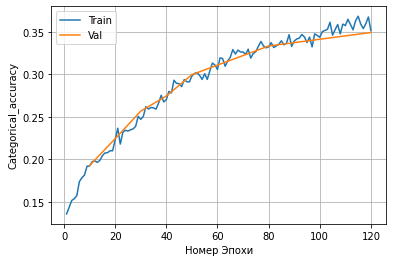

In [36]:
epochs_acc= []
cat_acc, cat_val =  [], []
epochs_steps = [10, 20, 30, 40, 50, 80, 120]

for i in range(len(epochs_steps)):
  csv_path = path + 'saved_models/model_1/model_1_epochs_' + str(epochs_steps[i]) 
  df_acc = pd.read_csv(csv_path + 'cat_acc.csv',names=['epoch','cat_acc'], skiprows=1)
  df_val = pd.read_csv(csv_path + 'cat_val_acc.csv',names=['epoch','cat_val_acc'], skiprows=1)
  
  if i == 0:
      epochs_acc.extend(list(df_acc['epoch'] + 1))
  else:
      epochs_acc.extend(list(df_acc['epoch'] + 1 + epochs_steps[i-1]))

  cat_acc.extend(list(df_acc['cat_acc']))
  cat_val.append(list(df_val['cat_val_acc'])[-1])

plt.plot(epochs_acc, cat_acc)
plt.plot(epochs_steps, cat_val)
plt.xlabel('Номер Эпохи')
plt.ylabel('Categorical_accuracy')
plt.legend(['Train', 'Val'])
plt.grid()
plt.show()




##5.6 Выполним предсказания на тестовых данных

In [ ]:
# Создадим генератор, выдающий преобразованные тестовые данные
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(directory=path_test,
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=False,
                                                         target_size=(IMG_SHAPE,IMG_SHAPE),
                                                         class_mode=None)

In [ ]:
# Функция генерирования csv файла с предсказаниями
def generate_prediction_csv(model, test_data_gen, name_of_file):
  ''' Функция генерирования csv файла с предсказаниями'''
  N = len(os.listdir(path_test_new))    # Количество тестовых рисунков
  filenames = test_data_gen.filenames   # Имена файлов генератора
  filenames = [filenames[i][2:] for i in range(N)]

  pred = model.predict(test_data_gen, batch_size=BATCH_SIZE) # Предсказания
  dict_pred = {'image_path':  filenames, 'emotion': emotions[np.argmax(pred, axis=1)]}    # Создаем словарь
  df = pd.DataFrame(data=dict_pred)
  # Отсортируем по порядку численному имена файлов
  df['num'] = [int(x[:-4]) for x in df['image_path']]
  df_pred = df.sort_values(by='num')[['image_path','emotion']]
  df_pred.to_csv(name_of_file + '.csv', sep=',', index=False)
  return df_pred

In [ ]:
# Другой способ реализации Функции генерирования csv файла с предсказаниями
'''
def generate_prediction_csv(model, path_test, IMG_SHAPE, name_of_file):
  # Функция генерирования csv файла с предсказаниями
  N = len(os.listdir(path_test_new))
  pred = {}
  for i in range(N):
    name = str(i) + '.jpg'
    img = plt.imread(path_test + name)
    img_mod = tf.image.resize(img, (IMG_SHAPE, IMG_SHAPE), tf.image.ResizeMethod.BILINEAR)
    img_mod =  img_mod * 1./255
    pred[name] = model.predict(img_mod[..., ::-1])

  df_pred = pd.DataFrame(pred,columns=['image_path', 'emotion'])
  df_pred.to_csv(name_of_file + '.csv', sep=',')
  return df_pred
'''

# Третий способ - создать датафрейм и создать генератор по нему через .flow_from_dataframe

In [ ]:
# Генерирую файл csv с предсказанием
%%time
df_pred = generate_prediction_csv(model_1, test_data_gen, path+'prediction_model_1_epochs_120')
df_pred.head()

| IMG_SHAPE     | BATCH_SIZE  | EPOHS| Time, hours |   categorical_accuracy  | 
| ------------- |-------------|-----| ----------------------| ----------------------|
|  64           | 128       | 30  | 4 |0.2356| 
|  64           | 128       | 40  | 5 |0.2532| 
|  64           | 128       | 60  | 6 |0.3017| 
|  64           | 128       | 80  | 7 |0.3406| 
|  64           | 256       | 60  |  |0.| 

# 4. Модель #2 - с применением Fine-Tuning
За основу возьмем сеть VGG19, обученную на ImageNet

In [ ]:
model_vgg19 = tf.keras.applications.VGG19(weights='imagenet')  
model_vgg19.summary()

574710816/574710816 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# Оставим все слои кроме последнего
base_model = tf.keras.Model([model_vgg19.input], model_vgg19.get_layer("fc2").output)
print("Количество слоев в базовой модели: ", len(base_model.layers))

#Разморозим всче слои
base_model.trainable =  True

fine_tune_at = 25
# все слои до fine_tune_at -- заморозим
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

base_model.summary()

Количество слоев в базовой модели:  25
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooli

In [ ]:
# Добавим выходной слой с n_emotions
model_2 = tf.keras.Sequential([
           base_model,
           tf.keras.layers.Dense(n_emotions, activation='softmax')
           ])

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 4096)              139570240 
                                                                 
 dense_4 (Dense)             (None, 9)                 36873     
                                                                 
Total params: 139,607,113
Trainable params: 36,873
Non-trainable params: 139,570,240
_________________________________________________________________


#4.1 Проверим время работы одного прохода нейронной сети

In [ ]:
%%timeit -n 10 -r 10
q_opt = model_2(np.random.rand(1, IMG_SHAPE, IMG_SHAPE, 3).astype(np.float32))

583 ms ± 45.7 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


## 4.2. Дообучение модели

In [ ]:
# Скомпилируем модель
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.CategoricalCrossentropy()
model_2.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

In [ ]:
# Обучим модель
EPOCHS = 1
history = model_2.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()]) # мы добавили коллбек для отрисовки прогресса

In [ ]:
# Генерирую файл csv с предсказанием
df_pred = generate_prediction_csv(model_2, path_test_new, 224, 'prediction_model_2')

ValueError: ignored

#5. Оптимизация модели

# 6. Проведите эксперименты с valence-arousal разложением эмоций, когда модель обучается не на самих эмоциях, а на их разложении по этим двум компонентам

# 7. Определение эмоции по видео с камеры

In [ ]:
import cv2
#from google.colab.patches import cv2_imshow

In [ ]:
cam_port = 0
cam = cv2.VideoCapture(cam_port)
  
# reading the input using the camera
result, image = cam.read()
print(result)
if result:
    cv2.imshow("GeeksForGeeks", image)
    cv2.waitKey(1)

False
